<a href="https://colab.research.google.com/github/letpires/ICU_prediction_sirio_libanes/blob/main/Leticia_Pires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

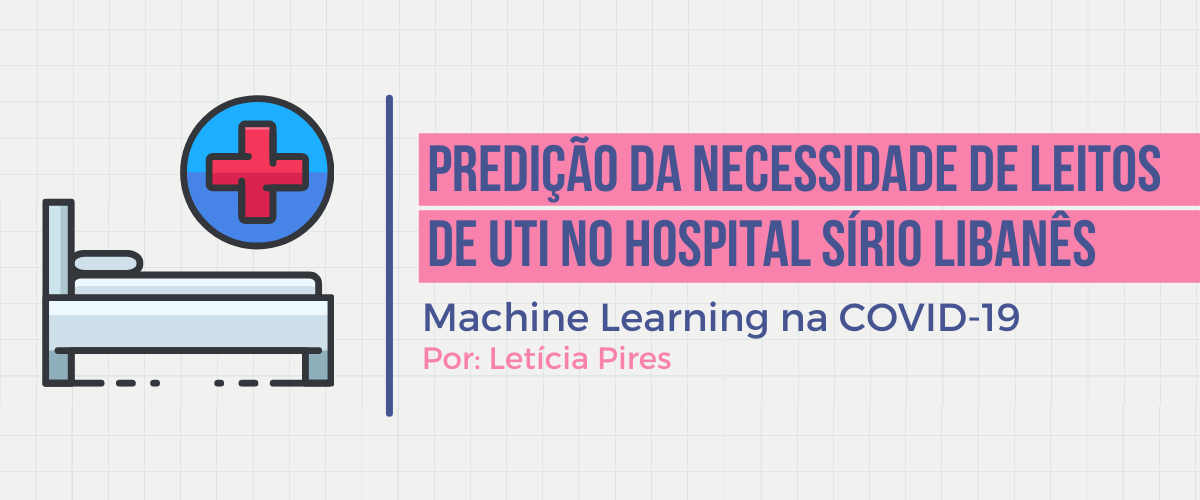

#**CONTEXTO**

A pandemia de COVID-19 atingiu o mundo inteiro, sobrecarregando os sistemas de saúde - despreparados para uma solicitação tão intensa e demorada de leitos de UTI, profissionais, equipamentos de proteção individual e recursos de saúde.
O Brasil registrou o primeiro caso COVID-19 em 26 de fevereiro e atingiu a transmissão na comunidade em 20 de março.

###**Problemática**

Há urgência na obtenção de dados precisos para melhor prever e preparar os sistemas de saúde e evitar colapsos, definido pela necessidade de leitos de UTI acima da capacidade (assumindo que recursos humanos, EPIs e profissionais estejam disponíveis), usando dados clínicos individuais - em vez de dados epidemiológicos e populacionais .

###**Objetivo** 

Criar um modelo de Machine Learning capaz de ajudar os médicos e enfermeiros do Hospital Sírio-Libanês a prever quais pacientes precisarão ser admitidos na unidade de terapia intensiva (UTI) devido a complicações da COVID-19 e, assim, definir qual a necessidade de leitos de UTI do Hospital a partir dos dados clínicos individuais disponíveis. 

Portanto, nosso modelo deve ser capaz de classificar se um paciente irá (1) ou não irá (0) para UTI, que é a nossa variável-alvo.

###**Tarefas** 

**Informações e dicas passadas pelo próprio Hospital e que serão seguidas para construção do modelo:**

1. Prever quais pacientes necessitarão de UTI;
2. Prever quais pacientes NÃO necessitarão de UTI.

###**Variável de interesse e Janela:**

- UTI ou não - ICU - (0,1);
- Janela de tempo - WINDOW - ['0-2', '2-4', '6-12', 'Above-12');

###**Critérios obrigatórios**
Não utilizar os dados quando o paciente deu entrada na UTI -> ICU = 1, pois estes já terão ido diretamente para a UTI nas 2 primeiras horas, não importando para a predição.

###**Aspectos dos dados**
Os dados foram anonimizados e escalados para manterem-se entre 0 e 1;

###**Entendendo as variáveis disponíveis:**

- Informações demgráficas (03);
- Agrupamento de doenças (09);
- Resultados de exames de sangue (36);
- Sinais vitais (06).

Diversas variáveis foram expandidas para versões média, mediana, máximo, mínimo, diff e diff relativo.

diff = valor máximo - valor mínimo;
diff relativo = diff / mediana

###**Estrutura de Dados:**

Neste banco de dados temos pacientes positivos para COVID-19 internados no Hospital Sírio Libânes de São Paulo-SP e Brasília-DF. De forma geral, temos até 5 entradas que representam dados de um mesmo paciente. Essas entradas são referentes à diferentes janelas de tempo (0-2, 2-4, 4-6, 6-12, >12) em que os pacientes foram acompanhados. Para cada uma das janelas, foram dosados diversos marcadores biológicos e sinais vitais.

Resumidamente, o layout dos dados estruturados e a estrutura do banco  é a seguinte:



**Tabela 1. Layout do dados e Estrutura de repetição dos dados no banco usado no desafio.**

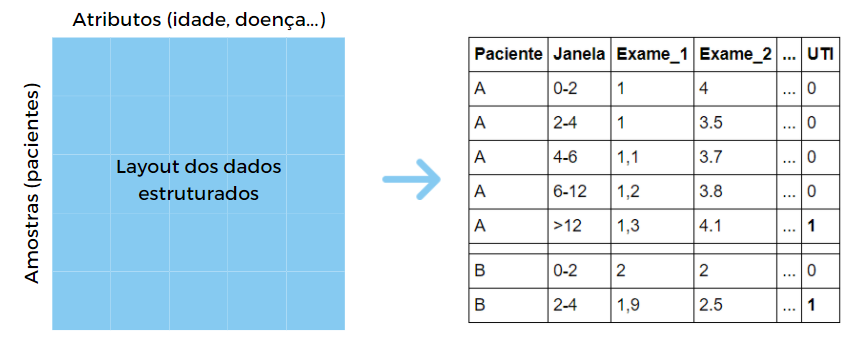

##**Referência/Recomendação**

Utilizei como base para criação dos modelos de ML e validação dos mesmos, o livro "Machine Learning: Guia de Referência Rápida - Trabalhando com dados estruturados em Python", de Matt Harrison e as aulas do Bootcamp.

#**ETAPAS DO PROJETO:**

No livro "Machine Learning: guia de referência rápida", o autor Matt Harrison, apresenta uma visão geral do processo de machine learning, desde a importação de bibliotecas até a implantação do modelo. Uni a leitura do livro com as aulas do Bootcamp e montei meu fluxo/roteiro pra implantação do modelo, como mostra a figura abaixo:

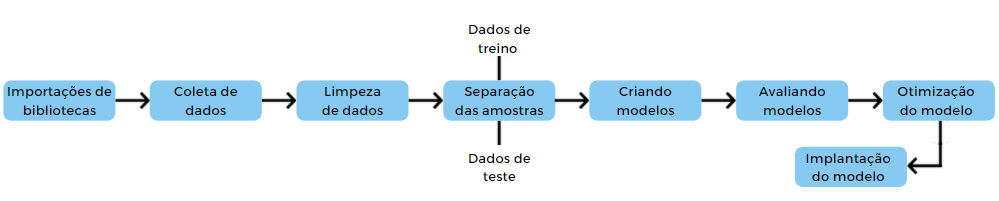

Para este projeto, faltou aprimorar e aperfeiçoar meus estudos para as etapas de Otimização do modelo, através de hiperparâmetros e implementação do modelo de fato.

#**1. IMPORTAÇÕES** 

Foi importado as bibliotecas utilizadas neste notebook para desenvolvimento e tratamento dos dados:

In [1]:
# Bibliotecas básicas para análise e visualização de dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas de modelos de Machine Learning (ML)
from sklearn.metrics import (plot_confusion_matrix, classification_report,
                             roc_auc_score, accuracy_score, 
                             plot_confusion_matrix)
from sklearn.model_selection import (cross_validate, StratifiedKFold, 
                                     RepeatedStratifiedKFold, train_test_split)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Biblioteca de métricas para análise do modelo ML
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import (ValidationCurve, LearningCurve) 
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.classifier import ClassBalance
from xgboost import XGBClassifier
from yellowbrick.style import set_palette
set_palette('flatui')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# **2. COLETA DE DADOS**

A base de dados da Covid-19 foi disponibilizada pelo Hospital Sírio Libanês - São Paulo e Brasília, no Kaggle, através da equipe do Bootcamp. Você pode conferir a base dados também [nesse link](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

In [2]:
dados = pd.read_excel("https://github.com/letpires/bootcamp_alura/blob/main/modulo_final/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

#**3. FUNÇÕES** 

Abaixo seguem as funções utilizadas para limpeza dos dados, criação de modelos e validação com métricas.

## 3.1 Funções para limpeza de dados

In [3]:
'''
Função que agrupa todos os grupos de dados de um paciente e atribui o valor 
ICU==1 na janela de até 2 horas.
'''

def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

In [4]:
'''
Função que agrupa cada valor da coluna PATIENT_VISIT_IDENTIFIER e 
preenche os dados faltantes das variáveis contínuas através do método 
bfill e ffill
'''

def fill_table(data):

    #Features_continuas contem grande parte das colunas de dados e NaN
    features_continuas_colunas = data.iloc[:, 13:-2].columns
    features_continuas = data.groupby("PATIENT_VISIT_IDENTIFIER", 
                                      as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    #Features_categoricas contem as 13 primeiras colunas do dataframe
    features_categoricas = data.iloc[:, :13]
    #Saida contém as duas últimas colunas WINDOW e ICU
    saida = data.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = data.columns
    return dados_finais

A função abaixo consiste em uma técnica elaborada pelo Thiago Gonçalves e Alan Spadinni nas aulas do Módulo 6, que consiste na criação de correlação de todas as linhas a partir da quarta coluna e antepenúltima (sem considerar `WINDOW` e `ICU`). Em seguida é gerado uma correlação e transformação dos valores para absoluto (não negativos). 

"A correlação vai de -1 a 1. Altas correlações aproximam de -1 e +1. Quando é próxima de -1 ocorre o inverso, então uma variável cresce e outra sobre. Quando é próxima de +1, é proporcional, quando uma sobre a outra também sobe."

Em seguida o `any` busca dentro dentro da matriz de correlação variáveis com alta correlação (valores acima do valor_corte) e através do laço `for`, isso é repetido pra todas as colunas. E caso seja verdadeiro, fica armazenado dentro de uma lista.

No entanto, fazendo somente essas ações não é possível, visto que, todas as colunas seriam excluídas. Por isso, podemos observar através da figura abaixo que a coluna na diagonal é igual a 1, e o triângulo superior é um espelho do inferior. Sendo assim, aplicando o `where`, `np.ones`(matriz com 1s) e `np.triu`(elimina triângulo abaixo da diagonal igual a 1).



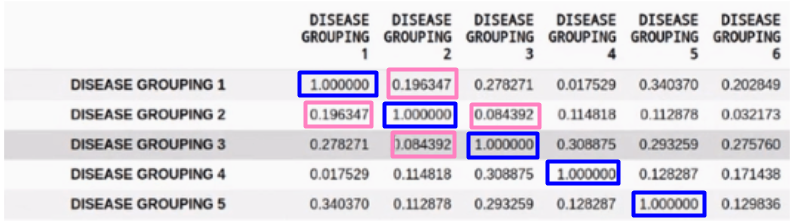

Acima temos a matriz de dados correlacionada, onde a linha azul mostra a diagonal com valor sempre igual a 1, pois são as mesmas colunas refletidas uma na outras. Abaixo dessa linha azul tenho o triângulo inferior, que como podemos ver pelo retângulo em rosa, representa o espelhamento do triângulo superior.

In [5]:
'''
Função que analisa a correlação entre as variáveis do banco de dados, cria uma
máscara para remover os dados espelhados e retorna os dados sem as variáveis 
com correlação maior que o valor de corte 0.95.
'''

def remove_corr_var(dados, valor_corte = 0.95):

  matriz_corr = dados.iloc[:,4:-2].corr().abs()
  matriz_superior = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k=1).astype(np.bool))
  excluir = [coluna for coluna in matriz_superior.columns if any(matriz_superior[coluna]> valor_corte)]
  
  return dados.drop(excluir, axis=1)


In [101]:
'''
Função que gera um  gráfico countplot.
'''

def plot_countplot_chart (dataframe, eixox, titulo):

  #criando uma figure, axes, alterando tamanho
  fig, ax = plt.subplots(figsize=(8,6))

  #criando o gráfico de barras
  sns.countplot(x=dataframe[eixox],  ax=ax, data=dataframe,  palette="Accent_r")

  #colocando valor nas barras
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    height + 3,
    '{:1.0f}'.format((height)),
    ha='center', fontsize=10)

  #adicionando título
  ax.set_title(titulo, fontdict={'fontsize':15})

  #mudando e nome e tamanho do label x
  ax.set_xlabel(eixox, fontdict={'fontsize':14})

  #mudando tamanho do label eixo y
  ax.set_ylabel('')

  #mudando tamanho dos labels dos ticks
  ax.tick_params(labelsize=14)

  #aumentando espessura linha inferior
  ax.spines['bottom'].set_linewidth(2.5)

  #remoção dos outros três axis
  for axis in ['top', 'right', 'left']:
      ax.spines[axis].set_color(None)
   
  #otimizar espaço da figure
  fig.tight_layout();

In [109]:
'''
Função que gera um  gráfico countplot para duas variáveis
'''

def plot_countplot_chart_two_features (dataframe, eixox, hue, titulo):

  #criando uma figure, axes, alterando tamanho
  fig, ax = plt.subplots(figsize=(8,6))

  #criando o gráfico de barras
  sns.countplot(x=dataframe[eixox], hue=hue, ax=ax, data=dataframe,  palette="Accent_r")

  #colocando valor nas barras
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    height + 3,
    '{:1.0f}'.format((height)),
    ha='center', fontsize=10)

  #adicionando título
  ax.set_title(titulo, fontdict={'fontsize':15})

  #mudando e nome e tamanho do label x
  ax.set_xlabel(eixox, fontdict={'fontsize':14})

  #mudando tamanho do label eixo y
  ax.set_ylabel('')

  #mudando tamanho dos labels dos ticks
  ax.tick_params(labelsize=14)

  #aumentando espessura linha inferior
  ax.spines['bottom'].set_linewidth(2.5)

  #remoção dos outros três axis
  for axis in ['top', 'right', 'left']:
      ax.spines[axis].set_color(None)
   
  #otimizar espaço da figure
  fig.tight_layout();

In [ ]:
def plot_violin_chart (dataframe, eixo_x, titulo, rotulo_x):


  sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=tips["total_bill"])

  #Função para gráficos tipo violinplot com somente uma variável
  plt.figure(figsize=(10,6))
  ax = sns.violinplot(x= eixo_x, inner="quartile", data = dataframe)
  plt.title(titulo, fontsize=14)
  plt.xlabel(rotulo_x)
  plt.show()

  return ax  

## 3.2 Funções para modelos de ML e métricas

In [6]:
'''
Função que recebe conjunto de dados e divide em dados de treino e dados de 
teste.
'''
def criar_treino_teste(dataset):
  np.random.seed(727356)
  x_columns = dataset.columns
  y = dataset["ICU"]
  x = dataset[x_columns].drop(["ICU","PATIENT_VISIT_IDENTIFIER"], axis=1)
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  return  x_train, x_test, y_train, y_test

A função abaixo calcula a importância dos atributos. A maioria dos modelos baseados em árvore oferece acesso a um atributo `.feature_importances` após o treinamento. Uma importância maior em geral implica que haverá um erro maior se o atributo for removido do modelo.

In [7]:
'''
Função que mostra quais colunas estão sendo mais importantes para o modelo
'''

def plotar_FeatureImportances (dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)
  
  fig,ax = plt.subplots(figsize=(15,35))

  fi_viz = FeatureImportances(modelo)
  fi_viz.fit(x_test,y_test)
  
  fi_viz.poof()

In [8]:
'''
Função que mostra o valor da acurácia do modelo, ou seja, a porcentagem de
classificações corretas. Quanto maior a acurácia, mais próximo da referência
ou valor real é o resultado encontrado.
'''

def acuracia (dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)
  #separa-se os dados aqui para evitar erros externos.
  print(f"A acurácia do Modelo Logístico para dados_limpos é de : {(accuracy_score(y_test, predicao_dados))*100 :.2f} %")

A função abaixo `roda_modelo` dá como resposta o valor AUC (Area Under The Curve) e o Classification Report que contém métricas como:



*  **Precision (precisão):** porcentagem de predições positivas que estavam corretas. Quão relevantes são os resultados?
*  **Recall ou sensibilidade:** porcentagem de valores positivos classificados corretamente. Quantos resultados relevantes são devolvidos?
*  **F1:** é a média harmônica de recall e precisão.


As fórmulas que representam essas definições são:


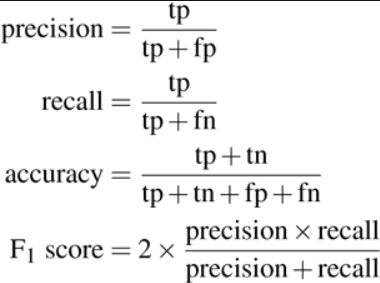

Onde:



*   **TP:** true positives ou verdadeiro positivo
*   **FP:** false positives ou falso positivo
*   **FN:** false negatives ou falso negativo
*   TN: true negatives ou verdadeiro negativo






In [9]:
'''
Função que retorna o valor AUC gerado pelo modelo que passamos e o 
Classification Report que contém informações importantes de métricas, como
precisão, recall e f1-score.
'''

def roda_modelo(modelo, dados):
  
  x_columns = dados.columns
  #dados de resposta
  y = dados["ICU"]
  #dados de entrada
  x = dados[x_columns].drop(["ICU"], axis=1)

  #criando variáveis de treino e teste
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  #treinando o modelo
  modelo.fit(x_train, y_train)
  #predizendo o modelo
  predicao = modelo.predict(x_test)
  #método de predição probabilistica importante para medir o AUC
  prob_predict = modelo.predict_proba(x_test)

  auc = roc_auc_score(y_test, prob_predict[:,1])
  print(f"AUC {auc}")
  print("\nClassification Report")
  print(classification_report(y_test, predicao))

In [10]:
'''
A função faz a separação de dados de treino e teste n vezes para diminuir o 
efeito de aleatoriedade gerado quando roda o modelo inúmeras vezes. Então deve 
ser passado o modelo, os dados e n (número de vezes que será rodado o modelo). 
Quanto maior o n, menor a aleatoriedade. Todas essas vezes são armazenadas numa 
lista. 
Também é calculado o desvio padrão junto com o AUC. Fazendo a média +/- 2xstd, 
tem chance de 95% do resultado apresentar-se mais dentro da realidade.
'''

def roda_n_modelos(modelo, dados, n):
  
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU"], axis=1)

  auc_lista = []

  # _ é utilizado como padrão, variável que não vamos utilizar os valores dados pela iteração
  for _ in range(n):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

    modelo.fit(x_train, y_train)
    prob_predict = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predict[:,1])
    auc_lista.append(auc)

  auc_medio = np.mean(auc_lista)
  auc_std = np.std(auc_lista)
  print(f"AUC médio =  {auc_medio}")
  print(f"Intervalo {auc_medio - 2* auc_std} - {auc_medio  + 2*auc_std}")

A função abaixo faz o processo de **Validação Cruzada.** A validação cruzada é uma técnica para avaliar a capacidade de generalização de um modelo, a partir de um conjunto de dados. Ou seja, busca-se estimar o quão preciso é este modelo na prática, o seu desempenho para um novo conjunto de dados.
 
Uma das maneiras de fazer a divisão desses dados é usando o método holdout, ele consiste em dividir os dados em 70-30 de maneira aleatória. Ou seja, 70% dos dados para treino e 30% para teste.

Para fazer isso, é utilizado o `cross_validate`, que tem como principal objetivo evitar problemas de aleatoriedade.

O cross_validate pega os dados, separa em porções de treino e teste, embaralha os dados e divide em k números de dobras (grupos), para assim termos conjuntos diferentes de dados para treino e teste. 
O resultado do nosso modelo vai ser a média dos valores de cada um desses grupos.

** A única desvantagem de utilizar o `cross_validate` é o desempenho, se você tiver uma base de dados muito grande rodar um cross validation vai ser muito custoso computacionalmente.



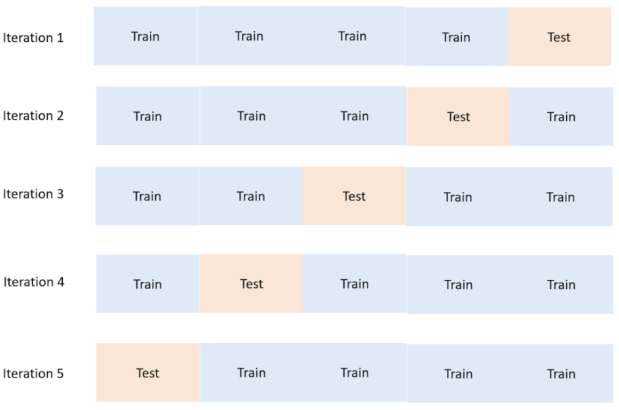

In [11]:
'''
Função que separa os dados de treino e teste e o RepeatedStratifiedKFold 
embaralha, fatia e repete este processo k vezes. Depois é aplicado o 
cross_validate para cruzar os dados. Em seguida, com os resultados em
dicionário, é feito print de uma média do score_test e train_score (que são as 
pontuações de treino e teste), assim como desvio padrão gerado pelo test_score.
'''

def roda_modelo_cv(modelo, dados, n_splits, n_repeats):
  
  np.random.seed(1231234)
  dados = dados.sample(frac=1).reset_index(drop=True)
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU"], axis=1)

  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])

  auc_std = np.std(resultados['test_score'])
  
  print(f"AUC {auc_medio} - {auc_medio_treino}")
  return auc_medio, auc_medio_treino

Uma métrica importante para avaliar os modelos de Machine Learning é a Matriz de Confusão. Ela pode ajudar a compreender o desempenho de um classificador.
Um classificador binário pode ter quatro resultados de classificação:

*   VP: verdadeiro positivo (a pessoa precisa de UTI e o modelo acertou)
*   VN: verdadeiro negativo (acerto para quando a pessoa não precisa de UTI)
*   FP: falso positivo (O modelo diz que é 1, mas a label é 0)
*   FN: falso negativo (o modelo diz que é 0, mas a label é 1)

As duas primeiras classificações representam a maneira correta.





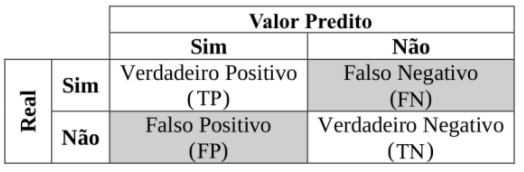

In [12]:
'''
Função com objetivo de criar uma matriz de confusão, que mostra o desempenho de
acertos e erros de cada modelo para as classes de dados.
'''

def plote_confusion_matrix(dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)


  fig, ax = plt.subplots(figsize=(7,7))

  figure = plot_confusion_matrix(modelo, x_test, y_test, ax=ax, cmap="PuBu", display_labels=['Não deve \n internar','Deve \n internar'])

  ax.set_title("Confusion matrix\n(Normalized values)", fontsize=16, fontweight="bold")
  ax.set_xlabel("Predicted label", fontsize=18)
  ax.set_ylabel("True label", fontsize=18)

Outra métrica utilizada é o `roc_auc`, ou área sob a curva ROC (Receiver Operator Characteristic). A curva ROC mostra o desempenho do classificador, exibindo taxa de verdadeiros positivos à medida que a taxa de falsos positivos muda. A regra geral é que o gráfico deve ter uma protuberância em direção ao canto superior esquerdo. Um traçado que esteja à esquerda e acima de outro sinaliza um desempenho melhor.

In [13]:
'''
Função que plota o gráfico com as métricas roc_auc, passando o modelo, o 
dataframe e o nome do data usado para ser plotado.
'''

def plotar_roc_auc(modelo,dados,name_dataset):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)
  #Separamos os dados de treino e teste

  modelo.fit(x_train, y_train) #treinamos
  predicao = modelo.predict(x_test)  #predizemos 

  # Plota-se a figura na qual ROCAUC irá realizar os calculos, pedindo apenas que
  #passemos o modelo
  fig, aux = plt.subplots(figsize=(9,9))
  roc_viz = ROCAUC(modelo)
  # Realiza-se também os calculos de pontuação que são apresentados na legenda
  # do gráfico
  roc_viz.score(x_test,y_test)
  plt.legend()
  plt.title(f"Curva ROC para {name_dataset} - MODELO {modelo.__class__.__name__}")
  plt.show()

As funções abaixo plotam as Curvas de Validação e Aprendizagem. Ambas são técnicas apresentadas por Harrison (2020) para selecionar melhor os modelos.

A **Curva de Validação** é uma forma de determinar um valor apropriado para um hiperparâmetro. Uma curva de validação é um gráfico que mostra como o desempenho do modelo repsonde a mudanças no valor do hiperparâmetro. O gráfico mostra tanto os dados de treinamento como de validação. As pontuações dos dados de validação nos pemritem inferir como o modelo responderia a dados não vistos anteriormente. Em geral, escolhemos um hiperparâmetro que maximize a pontuação dos dados de validação.

 >DICA: Utilize o parâmetro n_jobs para tirar proveito das CPUs e executar esse código mais rápido. Se esse parâmetro for definido com -1, todas as CPUs serão usadas.

 A **Curva de Aprendizagem** pode nos ajudar a seguinte pergunta: Quantos dados sserão necessários para selecionar o melhor modelo para o projeto? O gráfico mostra as instâncias de treinamento e a pontuação para validação cruzada a medida que criamos modelos com mais amostras. 
Se a pontuação da validação cruzada continuar a subir, por exemplo, poderá ser sinal de que mais dados ajudariam o modelo a ter melhor desempenho.
Se houver variabilidade (uma área sombreada grande) na pontuação de dados de treinamento, é sinal de que o modelo sofre de erros de viés e é simples demais (há subadequação). Se houver variabilidade na pontuação para validação cruzada, é porque o modelo está sujeito a erros de variância e é complicado demais (há superadequação).

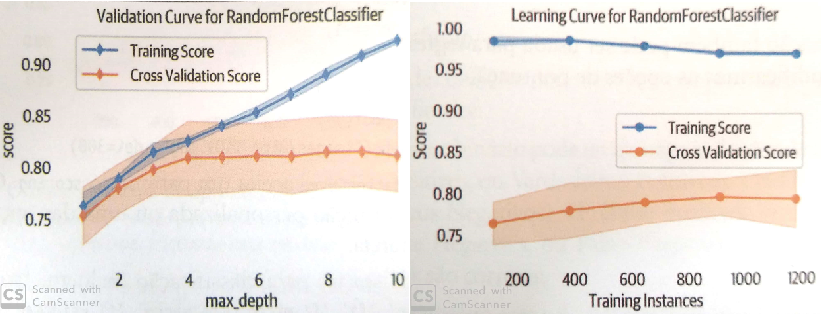

In [14]:
'''
Função que plota a Curva de Validação, que é uma forma de determinar um valor
apropriado para um hiperparâmetro. A curva mostra como o desempenho do modelo 
responde a mudanças no valor do hiperparâmetro.
'''

def validation_curve(modelo,dados,n_range_max, param):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)
  #Separamos os dados de treino e teste

  
  fig, aux = plt.subplots(figsize=(12,6))
  vc_viz = ValidationCurve(modelo, param_name=param, param_range=np.arange(1, n_range_max), cv=10, n_jobs=-1)

  vc_viz.fit(x_train,y_train)
  vc_viz.poof()

In [15]:
'''
Função que plota a Curva de Aprendizagem, que nos mostra quantos dados serão 
necessários para selecionar o melhor modelo.
'''

def learning_curve(modelo, dados):
  np.random.seed(165488)
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)

  fig,ax = plt.subplots(figsize=(12,6))
  lc3_viz=LearningCurve(modelo, cv=10)

  lc3_viz.fit(x_train,y_train)
  lc3_viz.poof()


# **4. LIMPEZA E EXPLORAÇÃO DOS DADOS**

Antes de aplicar os modelos é necessário preparar os nossos dados. Os modelos de ML não aceitam por exemplo strings. Então precisamos deixar os dados em numéricos e/ou categóricos.

Inicialmente vamos passar a função `fill_table` para agrupar a coluna `PATIENT_VISIT_IDENTIFIER` e preencher dados faltantes. Em seguida, realizou-se uma `query` por todas as colunas/linhas que possuem `WINDOW=='0-2'` and `ICU==1`, que deverão ser removidas da base de dados, como mencionado lá no início. Em seguida, utilizei o `dropna` para remover dados NaN.

In [16]:
dados_limpos = fill_table(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27

Ainda possuimos dados do tipo String, ou seja, precisamos limpar mais os dados, para que possamos rodar os modelos lá na frente. As colunas `AGE_PERCENTIL` e `WINDOW` são do tipo String. Para resolver isso, utilizei uma solução do livro de Matt Harrison, que mencionei no início. Criei colunas dummy a partir de colunas de string, então aplicando o `get_dummies`, foi criada uma coluna pra cada valor, sendo preenchido por 0 e 1. Além disso, inicialmente também foi aplicado o `prepare_window` para ficar somente com o quadro de pacientes que entram nas primeiras 2 horas. 



In [17]:
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos = pd.get_dummies(dados_limpos) 
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,WINDOW_0-2
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,0,0,0,1,0,0,0,0,1
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1,1,0,0,0,0,0,0,0,0,0,1
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,0,0,1,0,0,0,0,0,0,1
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,1,0,0,0,0,0,0,0,0,0,1
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073

In [18]:
# Checando a quantidade de colunas e linhas do dataframe
dados_limpos.shape

(352, 240)

In [19]:
# Checando se ainda existem dados Nan no dataframe.
check_for_nan = dados_limpos.isnull().values.any()
print (check_for_nan)

False


Então, depois de realizar a limpeza, conseguimos deixar o dataframe sem valores not a number e obtemos um Dataframe com 240 colunas e 352 linhas. No entanto, ainda podemos fazer outro tratamento nesses dados, porque talvez nem todas essas colunas sejam necessárias, podendo atrapalhar nas predições.

>Segundo Harrison (2020), "removemos qualquer coluna com uma correlação perfeita ou com uma correlação positiva ou negativa bem alta. A multicolinearidade pode causar impactos na interpretação da importância dos atributos e dos coeficientes em alguns modelos".

Por isso, no tópico abaixo, removo todas as colunas que possuem correlação perfeita ou alta correlação.

## **4.1 Excluindo dados correlacionados**

In [20]:
dados_limpos_sem_corr = remove_corr_var(dados_limpos)
dados_limpos_sem_corr

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,WINDOW_0-2
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,-0.932246,...,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,0,0,0,1,0,0,0,0,1
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,-0.959849,...,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1,1,0,0,0,0,0,0,0,0,0,1
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,-0.959849,...,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,0,0,1,0,0,0,0,0,0,1
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,-0.959849,...,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0,1,0,0,0,0,0,0,0,0,0,1
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,-0.959849,...,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.846633,-1.0,-0.884337,-1.0,-1.000000,-1.0,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.428571,-0.247863,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...

In [21]:
# Checando a quantidade de colunas e linhas do dataframe
dados_limpos_sem_corr.shape

(352, 109)

In [22]:
# Checando se ainda existem dados Nan no dataframe.
check_for_nan_sem_corr = dados_limpos_sem_corr.isnull().values.any()
print (check_for_nan_sem_corr)

False


Em resumo, os dados limpos apresentam 240 colunas, enquanto os dados limpos sem correlação ficaram com 109 colunas.

## **4.2 Explorando mais os dados**

Antes de criar o modelo, farei algumas análises de dados exploratórias, afim de ter uma noção dos dados ques estou trabahando.


####4.2.1 Número de pacientes por gênero

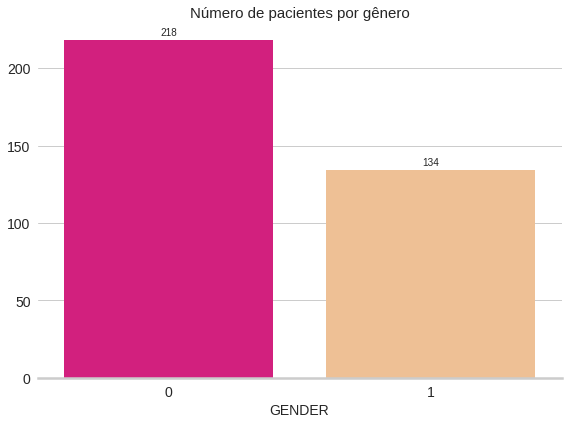

In [105]:
plot_countplot_chart(dados_limpos_sem_corr, 'GENDER', "Número de pacientes por gênero")

O gráfico mostra que aproximadamente 62% dos pacientes são do gênero 0 (Não foi especificado se é feminino ou masculino).

####4.2.2 Número de pacientes que foram ou não pra UTI

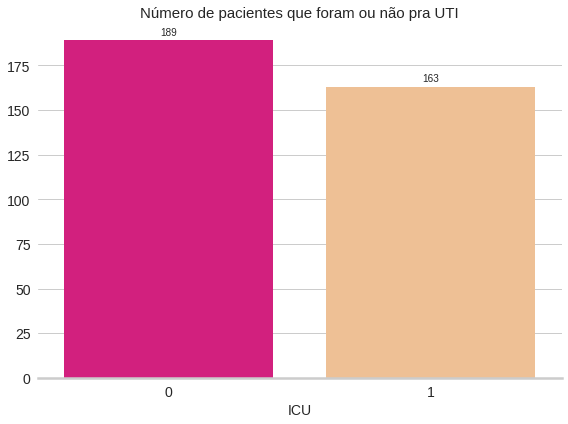

In [106]:
plot_countplot_chart(dados_limpos_sem_corr, 'ICU', "Número de pacientes que foram ou não pra UTI")

Com relação aos pacientes que foram ou não pra UTI, a amostra apresentou-se bem dividida. Em torno de 54% dos pacientes foram para a UTI e 46% não foram pra UTI.

####4.2.3 Gênero x UTI

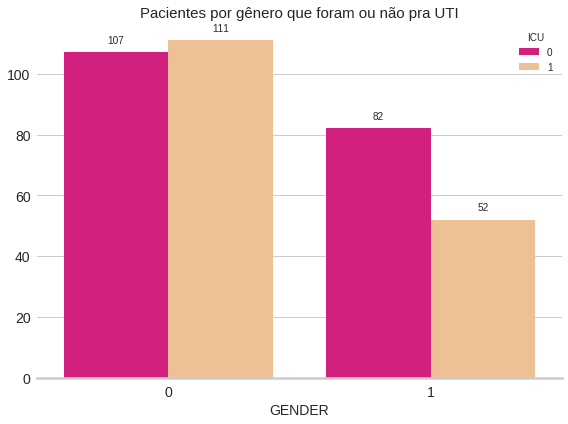

In [111]:
plot_countplot_chart_two_features(dados_limpos_sem_corr, "GENDER", "ICU", "Pacientes por gênero que foram ou não pra UTI")

O gráfico mostra que 107 pacientes do gênero 0 não foram para UTI, enquanto 111 do mesmo gênero foram para UTI. Com relação ao gênero 1, 82 pessoas não foram para a UTI e 52 foram para UTI.

## **4.3 Dados para treinamento**


Afim de evitar a multicolinearidade, vou utilizar para treinamento somente os dados limpos sem correlação:

* `DADOS_LIMPOS_SEM_CORR` = **Possui colunas sem alta correlação - 109 colunas**

# **5. EXECUTANDO MODELOS DE MACHINE LEARNING**

Este projeto consiste em classificar pacientes que devem ir para a UTI ou não. Dessa forma, será aplicado modelos de aprendizagem de máquina voltados a classificação. 

> A classificação é um método de *aprendizagem supervisionada* para atribuir um rótulo a uma amostra com base nos atributos. A aprendizagem supervisionada implica que temos rótulos para classificação ou números para regressão, os quais o algoritmo deve aprender (HARRISON, 2020).

Nesse projeto serão aplicados alguns modelos citados pelo autor Matt Harrison no livro "Machine Learning: Guia de Referência Prática".


*   Regressão Logística;
*   Árvore de Decisão;
*   Floresta Aleatória;
*   XGBoost.

## 5.1 - Regressão Logística

A Regressão Logística estima probabilidades usando uma função logística (Mas cuidado, porque apesar de ter regressão no nome, ela é usada para classificação). Este é um modelo padrão utilizado na maioria das ciências. Algumas das características do modelo são:


*   **Eficiência na execução:** pode usar o `n_jobs` se não estiver utilizando o `liblinear`;
*   **Pré-processamento dos dados:** Se `solver` estiver definido com 'sag' ou 'saga', padronize para que a convergência funcione. é capaz de lidar com entradas esparsas;
*   **Para evitar uma superadequação:** O parâmetro C controla a regularização.




Então, fiz a análise considerando os `dados_limpos_sem_corr` e aplicando a biblioteca `LogisticRegression` com número de iterações de 100.


In [ ]:
logistic_regression_dados_limpos_sem_corr = LogisticRegression(max_iter=100)

O Yellowbrick possui uma biblioteca que podemos utilizar para analisar melhor o modelo e entender a importância das features.




In [ ]:
plotar_FeatureImportances(dados_limpos_sem_corr, logistic_regression_dados_limpos_sem_corr)

Como resultado, podemos perceber que o `AGE_PERCENTIL_80th` possui um valor maior, mostrando que é uma feature muito importante para o modelo. Então quer dizer que: pacientes com idade acima de 80 anos podem necessitar mais de UTI?

Comparando com a realidade, mesmo não sabendo as doenças relacionadas ao paciente, eu responderia que sim, visto que pacientes com idade avançada apresentam um sistema imunológico menos eficaz. No entanto, não se pode afirmar nem generalizar isso, pois existem outros fatores que podem influenciar e que não é certo descartar pessoas abaixo dessa idade, por exemplo, que podem precisar também.

Além disso, tem também a feature `BLOODPRESSURE_DIASTOLIC_MEAN` que apresentou a menor importância na necessidade de internação na UTI.

### 5.1.1 Métricas

Em seguida, dividimos os nossos dados de treino e teste através da função  `criar_treino_teste`, que já está embutido na função métrica de acuracia


In [ ]:
acuracia(dados_limpos_sem_corr, logistic_regression_dados_limpos_sem_corr)

O modelo apresentou uma acurácia média de 65,9%. Ou seja, de todas as classificações, somente 65,91% foram corretas, o que não parece ser um bom resultado. 

>Um valor de Acurácia maior implica em dados mais próximos da realidade.

Além dessa métrica, temos que levar em conta outras métricas de avaliação. Abaixo é utilizada a matriz de confusão, explicada no tópico 3 ou [neste link](https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509).

In [ ]:
plote_confusion_matrix(dados_limpos_sem_corr, logistic_regression_dados_limpos_sem_corr )

Em resumo, o modelo acertou 23 vezes para pacientes que devem ser internados na UTI (verdadeiro positivo) e 35 vezes para pacientes que não devem ser internados (verdadeiro negativo). 

No entanto, o modelo previu 12 vezes para pacientes que devem ser internados (falso positivo), que na realidade não devem. E previu 18 vezes para pacientes que não deveriam ser internados (falso negativo), sendo que deveriam ser. 

Ou seja, em relação a essa métrica, o modelo não se apresentou eficaz. É insano prever que uma pessoa não precisa de leito, sendo que precisa. Assim como também, superlotar leitos de UTI com pessoas que não precisariam estar ali.

Com base nisso, podemos aprofundar mais as nossas métricas, através da acurácia, precisão, recall e f1 score. Utilizando o `Classification Report`  e passando os dados `y_test` e `predicao`, temos:

In [ ]:
roda_modelo(logistic_regression_dados_limpos_sem_corr, dados_limpos_sem_corr)

Para valores igual a 0 (pacientes que não precisam de UTI), possuimos uma precisão de 69% e para valores igual a 1 (pacientes que precisam de UTI) a precisão é de 73%. Segundo [este artigo](https://medium.com/@vitorborbarodrigues/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c#:~:text=O%20recall%20pode%20ser%20usada,prejudiciais%20que%20os%20Falsos%20Positivos.&text=O%20F1%2DScore%20%C3%A9%20simplesmente,e%20recall), a precisão pode ser usada em situação em que os falsos positivos são considerados mais prejudiciais que os falsos negativos, ou seja, será importante para o caso de estarmos internando mais pessoas do que o necessário, superlotando o hospital e fazendo com que pessoas que precisem de fato, fiquem sem leitos de UTI.

Já o RECALL pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudicionais que os Falsos Positivos. Por exemplo, o modelo deve de qualquer maneira encontrar todos os pacientes que precisam de UTI, mesmo que classifique os que não precise (situação de Falso Positivo). Ou seja, o modelo deve ter alto recall ou alta sensibilidade, pois imagina classificar pacientes que precisam de UTI como pacientes que não precisam, seria um problema muito grave.

No caso, nosso recall apresentou para 0, um desempenho alto de 81%, enquanto para a classe 1, 59%, demonstrando uma dificuldade em interpretar quem vai precisar de leitos de UTI, em comparação aos dados reais.

O f1 score nos mostra uma média harmônica entre precisão e recall. Para 0, apresentou 75% e para 1, 65% (representa que ou recall ou precisão estão baixos).





Outra métrica importante é a Curva ROC AUC como mostra o gráfico abaixo:


In [ ]:
plotar_roc_auc(logistic_regression_dados_limpos_sem_corr, dados_limpos_sem_corr, "Dados Limpos sem Correlação")

Uma regra geral é que o gráfico deve ter uma protuberância em direção ao canto superior esquerdo. Um traçado que esteja à esquerda e acima de outro sinaliza um desempenho melhor, como é o caso do gráfico acima.

O valor AUC ficou em 0.72, que pode ser considerado um bom desempenho. Modelos com AUC igual a 0 representam previsões 100% erradas. Quanto mais próximo de 1, melhor o modelo é.

Abaixo, também calculei o AUC médio, que leva em consideração o desvio padrão, n vezes, a fim de evitar a aleatoriedade dos dados e aumentar a chance do resultado estar dentro da realidade. 

In [ ]:
#AUC - métrica pra avaliar o desempenho
roda_n_modelos(logistic_regression_dados_limpos_sem_corr, dados_limpos_sem_corr, 100)

### 5.1.2 Seleção do Modelo

Afim de selecionar o melhor modelo, quantos dados são necessários? A função abaixo representa a Curva de Aprendizagem, que buscar responder a essa pergunta.

In [ ]:
learning_curve(logistic_regression_dados_limpos_sem_corr, dados_limpos_sem_corr)

Na Curva de Aprendizagem do Modelo de Regressão Logística, percebe-se que a curva de Validação Cruzada (verde) começa a subir, o que pode ser um sinal de que mais dados ajudariam o modelo a ter um desempenho melhor. No entanto, chega um momento que começa a estabilizar.

A pontuação da validação cruzada (curva verde) apresenta uma variabilidade (área sombreada grande), indicando que o modelo está sujeito a erros de variância e é complicado demais, ou seja, há superadequação.

E os dados de treinamento (linha azul) apresenta um desempenho ruim conforme adicionamos mais dados. 

## 5.2 Árvore de Decisão

Uma árvore de decisão é como ir a um médico que faz uma série de perguntas a fim de determinar a causa dos sintomas. Podemos usar um processo para criar uma árvore de decisão e ter uma série de perguntas para prever uma classe alvo. As vantagens desse modelo incluem suporte para dados não numéricos, pouca preparação dos dados, suporte para lidar com relacionamentos não lineares, a importância dos atributos é revelada e é fácil de explicar. Algumas das características do modelo são:


*   **Eficiência na execução:** para a criação, percorre cada um dos m atributos e ordena todas as n amostras;
*   **Pré-processamento dos dados:** Não é necessário escalar. É preciso se livrar dos valores ausentes e covertê-los em dados numéricos;
*   **Para evitar uma superadequação:** Defina `max_depth` com um número menor e aumente `min_impurity_decrease`.

Então, fiz a análise considerando os `dados_limpos_sem_corr` e aplicando a biblioteca `DecisionTreeClassifier`.

In [ ]:
decision_tree_dados_limpos_sem_corr = DecisionTreeClassifier(random_state=42, max_depth=3)

O Yellowbrick possui uma biblioteca que podemos utilizar para analisar melhor o 
modelo e entender a importância das features.

In [ ]:
plotar_FeatureImportances(dados_limpos_sem_corr, decision_tree_dados_limpos_sem_corr)

Como resultado, podemos perceber que o `RESPIRATORY_RATE_MEAN` possui um valor maior, mostrando que é uma feature muito importante para o modelo. 

#### 5.2.1 Métricas

Em seguida, dividimos os nossos dados de treino e teste através da função  `criar_treino_teste`, que já está embutido na função métrica de `acuracia`.

In [ ]:
acuracia(dados_limpos_sem_corr, decision_tree_dados_limpos_sem_corr)

O modelo apresentou uma acurácia média de 67,05%. Ou seja, de todas as classificações, somente 67,05% foram corretas, o que não parece ser um bom resultado. 

>Um valor de Acurácia maior implica em dados mais próximos da realidade.

Além dessa métrica, temos que levar em conta outras métricas de avaliação. Abaixo é utilizada a matriz de confusão, explicada no tópico 3 ou [neste link](https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509).

In [ ]:
plote_confusion_matrix(dados_limpos_sem_corr, decision_tree_dados_limpos_sem_corr)

Em resumo, o modelo acertou 23 vezes para pacientes que devem ser internados na UTI (verdadeiro positivo) e 36 vezes para pacientes que não devem ser internados (verdadeiro negativo). 

No entanto, o modelo previu 11 vezes para pacientes que devem ser internados (falso positivo), que na realidade não devem. E previu 18 vezes para pacientes que não deveriam ser internados (falso negativo), sendo que deveriam ser. 

Ou seja, em relação a essa métrica, o modelo não se apresentou eficaz. É insano prever que uma pessoa não precisa de leito, sendo que precisa. Assim como também, superlotar leitos de UTI com pessoas que não precisariam estar ali.

Com base nisso, podemos aprofundar mais as nossas métricas, através da acurácia, precisão, recall e f1 score. Utilizando o `Classification Report`  e passando os dados `y_test` e `predicao`, temos:

In [ ]:
roda_modelo(decision_tree_dados_limpos_sem_corr, dados_limpos_sem_corr)

Para valores igual a 0 (pacientes que não precisam de UTI), possuimos uma precisão de 62% e para valores igual a 1 (pacientes que precisam de UTI) a precisão é de 71%. Segundo [este artigo](https://medium.com/@vitorborbarodrigues/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c#:~:text=O%20recall%20pode%20ser%20usada,prejudiciais%20que%20os%20Falsos%20Positivos.&text=O%20F1%2DScore%20%C3%A9%20simplesmente,e%20recall), a **PRECISÃO** pode ser usada em situação em que os falsos positivos são considerados mais prejudiciais que os falsos negativos, ou seja, será importante para o caso de estarmos internando mais pessoas do que o necessário, superlotando o hospital e fazendo com que pessoas que precisem de fato, fiquem sem leitos de UTI.

Já o **RECALL** pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudicionais que os Falsos Positivos. Por exemplo, o modelo deve de qualquer maneira encontrar todos os pacientes que precisam de UTI, mesmo que classifique os que não precise (situação de Falso Positivo). Ou seja, o modelo deve ter alto recall ou alta sensibilidade, pois imagina classificar pacientes que precisam de UTI como pacientes que não precisam, seria um problema muito grave.

No caso, nosso recall apresentou para 0, um desempenho alto de 85%, enquanto para a classe 1, 41%, demonstrando uma dificuldade em interpretar quem vai precisar de leitos de UTI, em comparação aos dados reais.

O **f1 score** nos mostra uma média harmônica entre precisão e recall. Para 0, apresentou 72% e para 1, 52% (representa que ou recall ou precisão estão baixos).

In [ ]:
plotar_roc_auc(decision_tree_dados_limpos_sem_corr, dados_limpos_sem_corr, "Dados Limpos sem Correlação")

Uma regra geral é que o gráfico deve ter uma protuberância em direção ao canto superior esquerdo. Um traçado que esteja à esquerda e acima de outro sinaliza um desempenho melhor, como é o caso do gráfico acima.

O valor AUC ficou em 0.67, que pode ser considerado um desempenho baixo se comparado ao modelo anterior. Modelos com AUC igual a 0 representam previsões 100% erradas. Quanto mais próximo de 1, melhor o modelo é.

Abaixo, também calculei o AUC médio, que leva em consideração o desvio padrão, n vezes, a fim de evitar a aleatoriedade dos dados e aumentar a chance do resultado estar dentro da realidade.

In [ ]:
#AUC - métrica pra avaliar o desempenho
roda_n_modelos(decision_tree_dados_limpos_sem_corr, dados_limpos_sem_corr, 100)

#### 5.2.2 Seleção do Modelo

Com os resultados anteriores, podemos perceber que o modelo ainda não vem obtendo um bom desempenho. Para melhorar isso, podemos especificar mais o modelo com os hiperparâmetros, otimizando mais os modelos.

A Curva de Validação mostra como o desempenho do modelo responde as mudanças no valor do hiperparâmetro. Por isso, vou aplicar um `range` de 15 ao `max_depth`.

In [ ]:
validation_curve(decision_tree_dados_limpos_sem_corr, dados_limpos_sem_corr, 15, 'max_depth')

A linha azul representa os dados de treino. Essa linha mostra, que a cada valor `max_depth`, a pontuação se aproxima de 1.00, que pode levar a um **overfitting.** O overfitting ocorre quando o modelo se adaptou muito bem aos dados com os quais está sendo treinado, porém, não generaliza bem para novos dados. Ou seja, o modelo decorou o conjunto de dados de treino, mas não aprendeu de fato o que diferencia aqueles dados para quando enfrentar novos testes. E isso, podemos perceber através da linha verde (que representa os dados de teste), que fica sempre no intervalo de 0.50 a 0.75.

Afim de selecionar o melhor modelo, quantos dados são necessários? A função abaixo representa a Curva de Aprendizagem, que buscar responder a essa pergunta.

In [ ]:
learning_curve(decision_tree_dados_limpos_sem_corr, dados_limpos_sem_corr)

Na Curva de Aprendizagem do Modelo de Árvore de Decisão, percebe-se que a curva de Validação Cruzada (verde) começa a subir, o que pode ser um sinal de que mais dados ajudariam o modelo a ter um desempenho melhor. 

A pontuação da validação cruzada (curva verde) apresenta uma variabilidade (área sombreada grande), indicando que o modelo está sujeito a erros de variância e é complicado demais, ou seja, há superadequação.

E os dados de treinamento (linha azul) apresenta um desempenho ruim conforme adicionamos mais dados.

## 5.3 Floresta Aleatória

Uma floresta aleatória é um conjunto de árvores de decisão. Ela usa bagging para corrigir a tendência das árvores de decisão à superadequação. Ao criar árvores treinadas com subamostras e atributos aleatórios de dados, a variância é reduzida.

A ideia das florestas aleatórias é criar uma "floresta" de árvores de decisão treinadas em diferentes colunas de dados de treinamento.

Algumas características da Floresta Aleatória:


*   **Eficiência na execução:** deve criar j árvores aleatórias. Isso pode ser feito em paralelo usando `n_jobs`
*   **Pré-processamento dos dados:** não é necessário;
*   **Para evitar uma superadequação:** Adicione mais árvores (`n_estimators`). Use um valor menor para `max_depth`.


Então, fiz a análise considerando os `dados_limpos_sem_corr` e aplicando a biblioteca `RandomForestClassifier`.

In [ ]:
modelo_random_forest_dados_limpos_sem_corr = RandomForestClassifier(n_estimators=100)

O Yellowbrick possui uma biblioteca que podemos utilizar para analisar melhor o 
modelo e entender a importância das features.

In [ ]:
plotar_FeatureImportances(dados_limpos_sem_corr, modelo_random_forest_dados_limpos_sem_corr)

Como resultado, podemos perceber que o `RESPIRATORY_RATE_MEAN` possui um valor maior, mostrando que é uma feature muito importante para o modelo. 

### 5.3.1 Métricas

Em seguida, dividimos os nossos dados de treino e teste através da função  `criar_treino_teste`, que já está embutido na função métrica de `acuracia`.

In [ ]:
acuracia(dados_limpos_sem_corr,modelo_random_forest_dados_limpos_sem_corr)

O modelo apresentou uma acurácia de 65,91%. Ou seja, de todas as classificações, somente 65,91% foram corretas, o que não parece ser um bom resultado. 

>Um valor de Acurácia maior implica em dados mais próximos da realidade.

Além dessa métrica, temos que levar em conta outras métricas de avaliação. Abaixo é utilizada a matriz de confusão, explicada no tópico 3 ou [neste link](https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509).

In [ ]:
plote_confusion_matrix(dados_limpos_sem_corr, modelo_random_forest_dados_limpos_sem_corr)

Em resumo, o modelo acertou 24 vezes para pacientes que devem ser internados na UTI (verdadeiro positivo) e 34 vezes para pacientes que não devem ser internados (verdadeiro negativo). 

No entanto, o modelo previu 13 vezes para pacientes que devem ser internados (falso positivo), que na realidade não devem. E previu 17 vezes para pacientes que não deveriam ser internados (falso negativo), sendo que deveriam ser. 

Ou seja, em relação a essa métrica, o modelo não se apresentou eficaz. É insano prever que uma pessoa não precisa de leito, sendo que precisa. Assim como também, superlotar leitos de UTI com pessoas que não precisariam estar ali.

Com base nisso, podemos aprofundar mais as nossas métricas, através da acurácia, precisão, recall e f1 score. Utilizando o `Classification Report`  e passando os dados `y_test` e `predicao`, temos:

In [ ]:
roda_modelo(modelo_random_forest_dados_limpos_sem_corr, dados_limpos_sem_corr)

Para valores igual a 0 (pacientes que não precisam de UTI), possuimos uma precisão de 73% e para valores igual a 1 (pacientes que precisam de UTI) a precisão é de 67%. Segundo [este artigo](https://medium.com/@vitorborbarodrigues/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c#:~:text=O%20recall%20pode%20ser%20usada,prejudiciais%20que%20os%20Falsos%20Positivos.&text=O%20F1%2DScore%20%C3%A9%20simplesmente,e%20recall), a **PRECISÃO** pode ser usada em situação em que os falsos positivos são considerados mais prejudiciais que os falsos negativos, ou seja, será importante para o caso de estarmos internando mais pessoas do que o necessário, superlotando o hospital e fazendo com que pessoas que precisem de fato, fiquem sem leitos de UTI.

Já o **RECALL** pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudicionais que os Falsos Positivos. Por exemplo, o modelo deve de qualquer maneira encontrar todos os pacientes que precisam de UTI, mesmo que classifique os que não precise (situação de Falso Positivo). Ou seja, o modelo deve ter alto recall ou alta sensibilidade, pois imagina classificar pacientes que precisam de UTI como pacientes que não precisam, seria um problema muito grave.

No caso, nosso recall apresentou para 0, um desempenho alto de 70%, enquanto para a classe 1, 71%.

O **f1 score** nos mostra uma média harmônica entre precisão e recall. Para 0, apresentou 72% e para 1, 69% (representa que ou recall ou precisão estão baixos).

In [ ]:
plotar_roc_auc(modelo_random_forest_dados_limpos_sem_corr, dados_limpos_sem_corr, "Dados Limpos sem Correlação")

Comparando com os outros modelos, este apresentou um valor de AUC melhor, mas o modelo ainda depende de hiperparâmetros para melhorar seu desempenho. Pra otimizar o modelo, utizamos a curva de validação.

### 5.3.2 Seleção do Modelo

A Curva de Validação mostra como o desempenho do modelo responde as mudanças no valor do hiperparâmetro. Por isso, vou aplicar um `range` de 15 ao `max_depth`.

In [ ]:
validation_curve(modelo_random_forest_dados_limpos_sem_corr, dados_limpos_sem_corr,15,'max_depth')

A linha azul representa os dados de treino. Essa linha mostra, que a cada valor `max_depth`, a pontuação se aproxima de 1.00, que pode levar a um **overfitting.** O overfitting ocorre quando o modelo se adaptou muito bem aos dados com os quais está sendo treinado, porém, não generaliza bem para novos dados. Ou seja, o modelo decorou o conjunto de dados de treino, mas não aprendeu de fato o que diferencia aqueles dados para quando enfrentar novos testes. E isso, podemos perceber através da linha verde (que representa os dados de teste), que fica sempre no intervalo de 0.60 a 0.85.

Afim de selecionar o melhor modelo, quantos dados são necessários? A função abaixo representa a Curva de Aprendizagem, que buscar responder a essa pergunta.

In [ ]:
learning_curve(modelo_random_forest_dados_limpos_sem_corr,dados_limpos_sem_corr)

Na Curva de Aprendizagem do Modelo Random Forest, percebe-se que a curva de Validação Cruzada (verde) começa a subir, o que pode ser um sinal de que mais dados ajudariam o modelo a ter um desempenho melhor. Mas parece manter constante depois mesmo adicionando dados.

A pontuação da validação cruzada (curva verde) apresenta uma variabilidade (área sombreada grande), indicando que o modelo está sujeito a erros de variância e é complicado demais, ou seja, há superadequação.

E os dados de treinamento (linha azul) apresenta um desempenho constante. Adicionar mais dados, não vai influenciar no modelo.

## 5.4 XGBoost

O XGBoost é uma biblioteca popular, além do scikit-learn. Ele cria uma árvore fraca e, então, "melhora" as árvores subsequentes (faz um boosting) a fim de reduzir os erros residuais. O algoritmo tenta capturar e tratar qualquer padrão nos erros, até que pareçam ser aleatórios. Ele tem as seguintes propriedades:

*   **Eficiência na execução:** o XGBoost pode executar em paralelo. Utilize a opção `n_jobs` para informar o número de CPUs. Use a GPU para ter um desempenho melhor ainda.
*   **Pré-processamento dos dados:** não é necessário escalar com modelos baseados em árvore. é preciso codificar os dados da categoria;
*   **Para evitar uma superadequação:** o parâmetro `early_stopping_rounds=N` pode ser definido para interromper o treinamento caso não haja melhoras apóes N rodadas. As regularizações L1 e L2 são controladas por `reg_alpha` e `reg_lambda`, respectivamente. Números maiores são mais conservadores.

Então, fiz a análise considerando os `dados_limpos_sem_corr` e aplicando a biblioteca `XGBClassifier`.

In [ ]:
modelo_xgboost_dados_limpos_sem_corr = XGBClassifier(n_estimators=100,n_jobs=-1)

O Yellowbrick possui uma biblioteca que podemos utilizar para analisar melhor o 
modelo e entender a importância das features.

In [ ]:
plotar_FeatureImportances(dados_limpos_sem_corr, modelo_xgboost_dados_limpos_sem_corr)

Como resultado, podemos perceber que o `PH_VENOUS_MEDIAN` possui um valor maior, mostrando que é uma feature muito importante para o modelo. 

### 5.4.1 Métricas

Em seguida, dividimos os nossos dados de treino e teste através da função  `criar_treino_teste`, que já está embutido na função métrica de `acuracia`.

In [ ]:
acuracia(dados_limpos_sem_corr,modelo_xgboost_dados_limpos_sem_corr)

O modelo apresentou uma acurácia de 72,73%. Ou seja, de todas as classificações, somente 72,73% foram corretas, o que não parece ser um bom resultado. 

>Um valor de Acurácia maior implica em dados mais próximos da realidade.

Além dessa métrica, temos que levar em conta outras métricas de avaliação. Abaixo é utilizada a matriz de confusão, explicada no tópico 3 ou [neste link](https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509).

In [ ]:
plote_confusion_matrix(dados_limpos_sem_corr,modelo_xgboost_dados_limpos_sem_corr)

Em resumo, o modelo acertou 28 vezes para pacientes que devem ser internados na UTI (verdadeiro positivo) e 36 vezes para pacientes que não devem ser internados (verdadeiro negativo). 

No entanto, o modelo previu 11 vezes para pacientes que devem ser internados (falso positivo), que na realidade não devem. E previu 13 vezes para pacientes que não deveriam ser internados (falso negativo), sendo que deveriam ser. 



Com base nisso, podemos aprofundar mais as nossas métricas, através da acurácia, precisão, recall e f1 score. Utilizando o `Classification Report`  e passando os dados `y_test` e `predicao`, temos:

In [ ]:
roda_modelo(modelo_xgboost_dados_limpos_sem_corr, dados_limpos_sem_corr)

In [ ]:
plotar_roc_auc(modelo_xgboost_dados_limpos_sem_corr, dados_limpos_sem_corr, "Dados Limpos sem Correlação")

Comparando com o modelo da Floresta Aleatória, este apresentou um valor de AUC melhor, mas o modelo ainda depende de hiperparâmetros para melhorar seu desempenho. Pra otimizar o modelo, utizamos a curva de validação.

### 5.4.2 Seleção do Modelo

A Curva de Validação mostra como o desempenho do modelo responde as mudanças no valor do hiperparâmetro. Por isso, vou aplicar um `range` de 6 ao `max_depth`.

In [ ]:
validation_curve(modelo_xgboost_dados_limpos_sem_corr, dados_limpos_sem_corr,6,'max_depth')

A linha azul representa os dados de treino. Essa linha mostra, que a cada valor `max_depth`, a pontuação se aproxima de 1.00, que pode levar a um **overfitting.** O overfitting ocorre quando o modelo se adaptou muito bem aos dados com os quais está sendo treinado, porém, não generaliza bem para novos dados. Ou seja, o modelo decorou o conjunto de dados de treino, mas não aprendeu de fato o que diferencia aqueles dados para quando enfrentar novos testes. E isso, podemos perceber através da linha verde (que representa os dados de teste), que fica sempre no intervalo de 0.65 a 0.75.

Afim de selecionar o melhor modelo, quantos dados são necessários? A função abaixo representa a Curva de Aprendizagem, que buscar responder a essa pergunta.

In [ ]:
learning_curve(modelo_xgboost_dados_limpos_sem_corr,dados_limpos_sem_corr)

Na Curva de Aprendizagem do Modelo XGBoost, percebe-se que a curva de Validação Cruzada (verde) começa a subir, o que pode ser um sinal de que mais dados ajudariam o modelo a ter um desempenho melhor. 

A pontuação da validação cruzada (curva verde) apresenta uma variabilidade (área sombreada grande), indicando que o modelo está sujeito a erros de variância e é complicado demais, ou seja, há superadequação.

E os dados de treinamento (linha azul) apresenta um desempenho constante. Adicionar mais dados, não vai influenciar no modelo.


# 6. VALIDAÇÃO CRUZADA

Para evitar que nosso modelo fique viciado, aplicamos a validação cruzada, que avalia a capacidade de generalização de um modelo a partir de um conjunto de dados.

## 6.1 Regressão Logística

In [ ]:
roda_modelo_cv(logistic_regression_dados_limpos_sem_corr,dados_limpos_sem_corr,5,10)

##6.2 Árvore de Decisão

In [ ]:
roda_modelo_cv(decision_tree_dados_limpos_sem_corr,dados_limpos_sem_corr,5,10)

## 6.3 Floresta Aleatória

In [ ]:
roda_modelo_cv(modelo_random_forest_dados_limpos_sem_corr,dados_limpos_sem_corr,5,10)

## 6.4 XGBoost

In [ ]:
roda_modelo_cv(modelo_xgboost_dados_limpos_sem_corr,dados_limpos_sem_corr,5,10)

A partir disso, conclui-se que o melhor modelo foi o **Random Forest ou Floresta Aleatória**.

# CONCLUSÕES

Considerando a situação emergencial do COVID-19 no Brasil, a necessidade de uma solução rápida, todo esse processo de criação de um modelo deve ser tratado da forma mais séria possível. Trabalhar com dados reais pode ser algo muito complexo nesse caso;

Mas em resumo, consegui tirar algumas conclusões:


*   O modelo XGBoost apresentou uma acurácia melhor;
*   O modelo de Floresta Aleatória apresentou um valor de AUC melhor;
*   Uma feature que pareceu ser importante é a `RESPIRATORY_RATE_MEAN`, que foi a feature importance comum aos dois conjuntos de dados analisados;
*   Avaliando alguns modelos pela curva de aprendizagem, percebe-se que há uma necessidade de aumentar a quantidade de dados para melhorar o desempenho;
 

O projeto está finalizado pra essa etapa inicial de entrega, mas pretendo ir aperfeiçoando conforme meus estudos. Tive algumas limitações na construção do projeto, por falta de conhecimento suficiente sobre os modelos de ML e hiperparâmetros de modelos.



# **REFERÊNCIAS**



*  HARRISON, Matt. Machine Learning: Guia de Referência Rápida - Trabalhando com dados estruturados em Python. São Paulo. 2020. Disponível neste [link](https://www.amazon.com.br/Machine-Learning-Refer%C3%AAncia-Trabalhando-Estruturados/dp/857522817X);

*  Biblioteca YellowBrick. Disponível neste [link](https://www.scikit-yb.org/en/latest/index.html)

*  Biblioteca Scikit Learn. Disponível neste [link](https://www.scikit-yb.org/en/latest/index.html);

*  SANTANA, Rodrigo. Validação Cruzada: aprenda de forma simples como usar. 2020. Disponível neste [link](https://minerandodados.com.br/validacao-cruzada-aprenda-de-forma-simples-como-usar-essa-tecnica/);

*  KAGGLE. Base de dados disponibilizada pelo Hospital Sírio Libanês. Disponível neste [link](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19);

*  SOUZA, Emanuel. Entendendo o que é matriz de confusão. 2019. Disponível neste [link](https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509);

*  RODRIGUES, Vitor. Métricas de avaliação. 2019. Disponível neste [link](https://medium.com/@vitorborbarodrigues/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c#:~:text=O%20recall%20pode%20ser%20usada,prejudiciais%20que%20os%20Falsos%20Positivos.&text=O%20F1%2DScore%20%C3%A9%20simplesmente,e%20recall).

Para a realização deste projeto, foram gastas 30 horas.

####**OBRIGADA POR LER ESTE TRABALHO :)**

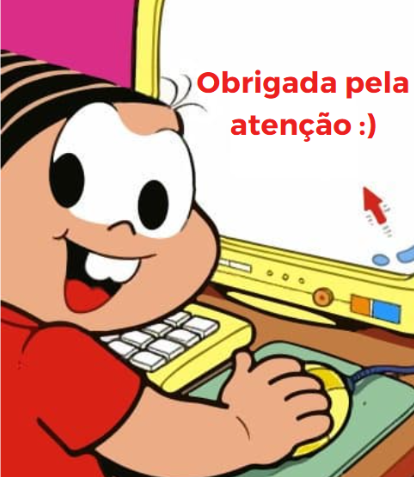